In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
from astropy.time import Time
import warnings

from matplotlib.ticker import MultipleLocator

In [3]:
import sys

sys.path.append('../tools/')
from dust_extinction import calALambda
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'b': '#1f77b4',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3',
    'darkgrey': '0.2',
    'palegrey': '0.6'
}

In [4]:
# SN metadata


class SN_meta:

    def __init__(self, name, z, tmax, ebv, files, IR_thres=1.1e4):
        self.name = name
        self.z = z
        self.t_max_mjd = tmax - 2400000.5
        self.ebv = ebv
        files = np.sort(files)
        self.NIRfiles = files[[(np.loadtxt(spec)[-1, 0] > IR_thres)
                               for spec in files]]
        self.NIRfiles = self.NIRfiles[[
            not ('GNIRS_v' in spec) for spec in self.NIRfiles
        ]]
        self.OPTfiles = files[[(np.loadtxt(spec)[-1, 0] < IR_thres)
                               for spec in files]]
        print(self.NIRfiles)


jgb = SN_meta('SN\,2020jgb',
              z=0.0307,
              tmax=2458986.91,
              ebv=0.404,
              files=glob.glob('./SN2020jgb/*ascii'))
byg = SN_meta('SN\,2018byg',
              z=0.066,
              tmax=2458258.99,
              ebv=0.032,
              files=glob.glob('./SN2018byg/ZTF18aaqeasu*ascii'))
hnk = SN_meta('SN\,2016hnk',
              z=0.0161,
              tmax=2457689.98,
              ebv=0.0224,
              files=glob.glob('./SN2016hnk/*dat'))
fe = SN_meta('SN\,2011fe',
             z=0.000804,
             tmax=2455814.27,
             ebv=0.008,
             files=glob.glob('./SN2011fe/*dat'))
da = SN_meta('SN\,2004da',
             z=0.015881,
             tmax=2453189.7,
             ebv=0.109,
             files=glob.glob('./SN2004da/*flm'))

['./SN2020jgb/ZTF20aayhacx_20200609_Gemini-N.ascii']
['./SN2018byg/ZTF18aaqeasu_20180603_Keck1_v1.ascii']
['./SN2016hnk/2016hnk_2016-11-04_01-57-23.700_Gemini-S_Flamingos-2_PESSTO.dat'
 './SN2016hnk/2016hnk_2016-11-06_02-05-03.429_ESO-NTT_Sofi_PESSTO.dat']
['./SN2011fe/SN2011fe_2011-08-28_04-05-00_HST_STIS_HST-Ia.dat'
 './SN2011fe/SN2011fe_2011-08-31_06-00-00_HST_STIS_HST-Ia.dat'
 './SN2011fe/SN2011fe_2011-09-03_09-07-00_HST_STIS_HST-Ia.dat'
 './SN2011fe/SN2011fe_2011-09-07_08-53-00_HST_STIS_HST-Ia.dat'
 './SN2011fe/SN2011fe_2011-09-10_09-22-00_HST_STIS_HST-Ia.dat'
 './SN2011fe/SN2011fe_2011-09-13_16-05-00_HST_STIS_HST-Ia.dat']
[]


In [5]:
def plot_box_spec(wave, flux):
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave) / 2
    wv_plot = np.append(
        wave[0] - (wave[1] - wave[0]) / 2,
        np.append(np.repeat(wv_plot[0:-1], 2),
                  wave[-1] + (wave[-1] - wave[-2]) / 2))

    return wv_plot, flux_plot

5.0
15.0
19.0
25.0
Try the observation date.
Try the observation date.
Try the observation date.


/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_72549/3036759262.py:30: RuntimeWarning: invalid value encountered in log10
  np.log10(fl / norm_flux) - h * spec_num_norm[num],
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_72549/3036759262.py:30: RuntimeWarning: invalid value encountered in log10
  np.log10(fl / norm_flux) - h * spec_num_norm[num],
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_72549/3036759262.py:100: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_72549/3036759262.py:159: RuntimeWarning: invalid value encountered in log10
  np.log10(fl_bin / norm_flux) - h * num,


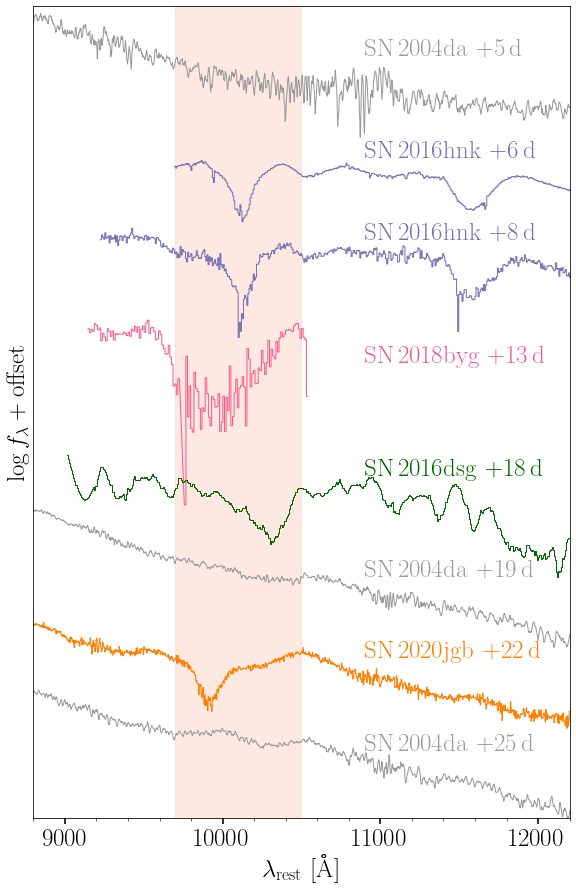

In [6]:
rv = 3.1

fig, ax = plt.subplots(figsize=(8, 12.5))

h = .82
v = 11500

normIa = glob.glob('./NIR_Marion09/*04da*')
normIa.sort()

spec_num_norm = [0, 4, 6, 8]
num = -1
for spec in normIa:  #normal Ia from Marion+09
    with open(spec) as f:
        ll = f.readlines()
    for l in ll:
        if 'Phase' in l:
            phase = float(l.split('=')[1].split("d")[0])
            print(phase)
    num += 1
    if num == 1:
        continue
    spec_df = pd.read_csv(spec,
                          comment='#',
                          delim_whitespace=True,
                          header=None)
    wv, fl = spec_df[1].values * 1e4, spec_df[2].values
    norm_flux = np.nanmedian(fl[np.where((wv > 10300) & (wv < 10500))])
    ax.plot(wv,
            np.log10(fl / norm_flux) - h * spec_num_norm[num],
            color=color_map['palegrey'],
            linewidth=1)
    if phase < 0:
        ax.text(10900,
                .1 * h - h * 1.0 * spec_num_norm[num],
                r'$\mathrm{SN\,2004da}$' +
                ' $-{:.0f}\,\mathrm d$'.format(np.abs(phase)),
                color=color_map['palegrey'])
    else:
        ax.text(10900,
                .4 * h - h * 1.06 * spec_num_norm[num],
                r'$\mathrm{SN\,2004da}$' +
                ' $+{:.0f}\,\mathrm d$'.format(np.abs(phase)),
                color=color_map['palegrey'])

spec_num = [1, 2, 3, 7, 9]
num = -1
for sn, c in zip([hnk, byg, jgb],
                 ['purple', 'magenta', 'orange', 'green']):
    for spec in sn.NIRfiles:
        spec_df = pd.read_csv(spec,
                              comment='#',
                              delim_whitespace=True,
                              header=None)

        with open(spec) as f:
            ll = f.readlines()
        # brute force
        mjd_found = False
        for l in ll:
            if 'MJD' in l:
                mjd_found = True
                if '=' in l and 'at start' in l:
                    mjd_obs = float(l.split('=')[1].split("'")[1])
                elif '=' in l and '/' in l:
                    mjd_obs = float(l.split('=')[1].split('/')[0])
                elif '=' in l:
                    mjd_obs = float(l.split('=')[1])
                elif ':' in l:
                    mjd_obs = float(l.split(':')[1])
                break
        if not mjd_found:
            print('Warning: MJD-obs not found in {}!'.format(spec))
            print('Try the observation date.')
            year = '_20'
            pos_dat = spec.find(str(year)) + 1
            try:
                year_obs = spec[pos_dat:pos_dat + 4]
                mon_obs = spec[pos_dat + 4:pos_dat + 6]
                date_obs = spec[pos_dat + 6:pos_dat + 8]
                mjd_obs = Time('{}-{}-{}'.format(year_obs, mon_obs,
                                                 date_obs)).mjd
            except:
                mjd_obs = Time(spec[pos_dat:pos_dat + 10]).mjd

        phase = (mjd_obs - sn.t_max_mjd) / (1 + sn.z)
        if phase < 1:
            continue
        num += 1

        try:
            if 'Keck' in spec:
                fl_unc = spec_df[3].values
            else:
                fl_unc = spec_df[2].values

                if 'P60' in spec or 'P200' in spec:
                    fl_unc **= .5
        except:
            warnings.warn("No flux uncertainty in the datafile!")
            # set relative uncertainty to be 10%
            fl_unc = np.ones_like(spec_df[0].values) * 1e-1 * np.median(
                spec_df[0].values)
        fl_unc0 = fl_unc.copy()

        wv0, fl0 = spec_df[0].values, spec_df[1].values,
        E0 = 10**(0.4 * calALambda(wv0, rv, sn.ebv))
        fl0 = fl0 * E0

        if sn == byg:
            out = data_binning(np.array(
                [spec_df[0].values, spec_df[1].values, fl_unc]).T,
                               size=10)
        else:
            out = data_binning(np.array(
                [spec_df[0].values, spec_df[1].values, fl_unc]).T,
                               size=.1)
        wv, fl = plot_box_spec(out[:, 0], out[:, 1])
        wv, fl = wv[fl > 1e-2 * np.nanmedian(fl)], fl[fl > 1e-2 *
                                                      np.nanmedian(fl)]

        fl_unc = np.repeat(out[:, -1], 2)

        E = 10**(0.4 * calALambda(wv, rv, sn.ebv))
        fl = fl * E

        norm_flux = np.nanmedian(fl[np.where((wv / (1 + sn.z) > 10300)
                                             & (wv / (1 + sn.z) < 11000))])
        '''ax.plot(wv0 / (1 + sn.z),
                np.log10(fl0 / norm_flux) - h * spec_num[num],
                color=color_map[c],
                linewidth=1,
                alpha=0.2)'''
        ax.plot(wv / (1 + sn.z),
                np.log10(fl / norm_flux) - h * spec_num[num],
                color=color_map[c],
                linewidth=1)

        y = .15 * h - 1.0 * h * spec_num[num]
        if abs(mjd_obs - sn.t_max_mjd - 13) < 1:  #18byg
            y -= 0.5 * h
        elif abs(mjd_obs - sn.t_max_mjd - 22) < 2:  #20jgb
            y -= 0.10 * h

        ax.text(10900,
                y,
                r'$\mathrm{' + sn.name + '}$' +
                ' $+{:.0f}\,\mathrm d$'.format(np.abs(phase)),
                color=color_map[c])

num = 4.9
# original NIR spec
dat = np.loadtxt(
    './SN2016dsg/2016dsg_2016-03-09_02-18-46.1019_ESO-NTT_Sofi_None.ascii')
wv, fl_bin = plot_box_spec(dat[:, 0], dat[:, 2])
norm_flux = np.nanmedian(fl_bin[np.where((wv / (1 + 0.04) > 10300)
                                         & (wv / (1 + 0.04) < 11000))])
ax.plot(wv / (1 + 0.04),
        np.log10(fl_bin / norm_flux) - h * num,
        color='darkgreen',
        linewidth=1)
y = .18 * h - 1.0 * h * num
ax.text(10900,
        y,
        r'$\mathrm{SN\,2016dsg}$' + ' $+18\,\mathrm d$',
        color='darkgreen')

ax.fill_betweenx(y=ax.get_ybound(), x1=9700, x2=10500, color='#fc9272', alpha=.2)

ax.set_xlim(8800, 12200)
ax.set_ylim(-0.99 * h * (spec_num_norm[-1] + 1), h)
ax.set_ylabel(r'$\log f_\lambda + \mathrm{offset}$')
ax.set_xlabel(r'$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$',
              **{'fontname': 'Times New Roman'})
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.set_yticks([])

fig.subplots_adjust(left=0.06, bottom=0.051, top=0.953, right=0.991)
fig.savefig('../paper/figures/NIR_spec_comp.pdf', bbox_inches='tight')

In [7]:
from scipy.interpolate import splrep, splev

In [8]:
ebh = SN_meta('iPTF13ebh',
              z=0.0133,
              tmax=2456623.4,
              ebv=0.05,
              files=glob.glob('./iPTF13ebh/*.dat'))
by = SN_meta('SN\,1999by',
             z=0.002128,
             tmax=2451487.5,
             ebv=0.014,
             files=glob.glob('./SN1999by/SN1999by*dat'))
es = SN_meta('SN\,2002es',
             z=0.018,
             tmax=2452518.8,
             ebv=0.16,
             files=glob.glob('./SN2002es/SN2002es*.ascii'))

['./iPTF13ebh/iPTF13ebh_20131214_Magellan_FIRE.dat'
 './iPTF13ebh/iPTF13ebh_20131220_Magellan_FIRE.dat']
['./SN1999by/SN1999by_1999-05-24_MDM.dat']
[]


/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_72549/13319272.py:123: RuntimeWarning: divide by zero encountered in log10
  np.log10(fl0 / norm_flux) - h * (spec_num[num] - 0.15),
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_72549/13319272.py:123: RuntimeWarning: invalid value encountered in log10
  np.log10(fl0 / norm_flux) - h * (spec_num[num] - 0.15),
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_72549/13319272.py:123: RuntimeWarning: divide by zero encountered in log10
  np.log10(fl0 / norm_flux) - h * (spec_num[num] - 0.15),
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_72549/13319272.py:123: RuntimeWarning: invalid value encountered in log10
  np.log10(fl0 / norm_flux) - h * (spec_num[num] - 0.15),
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_72549/13319272.py:123: RuntimeWarning: divide by zero encountered in log10
  np.log10(fl0 / norm_flux) - h * (spec_num[num] - 0.15),
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx800

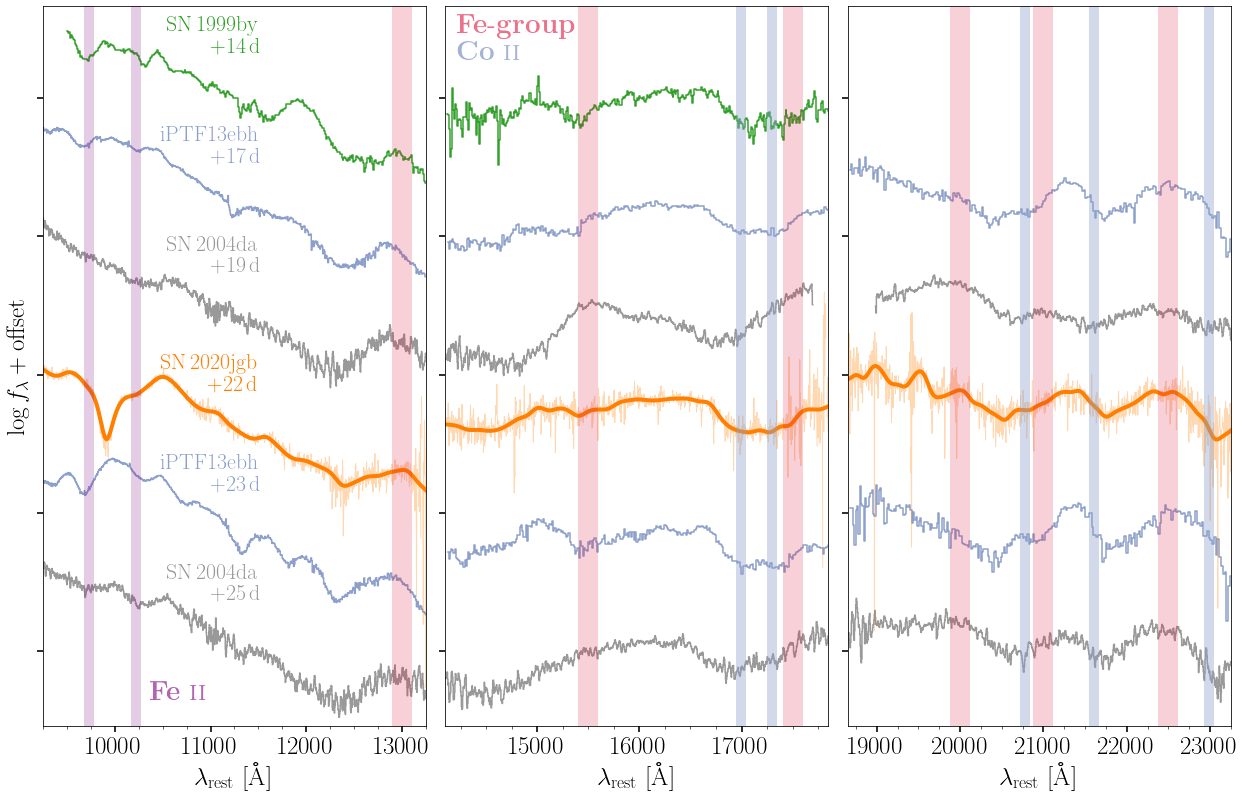

In [9]:
rv = 3.1

fig, Ax = plt.subplots(1, 3, figsize=(16.5, 10), sharey=True)

h = 0.79
V = [9350, 16000, 20000]
ran = [[9250, 13250], [14100, 17850], [18650, 23250]]

da = glob.glob('./NIR_Marion09/*04da*')
da.sort()
normIas = [
    da[2:],
    by.NIRfiles,
    #glob.glob('./NIR_Marion09/*04ab*'),
    ebh.NIRfiles,
]
for k in range(3):
    ax = Ax[k]
    v = V[k]

    spec_num = [[2, 5], [0], [1, 4]]
    names = [
        r'$\mathrm{SN\,2004da}$', r'$\mathrm{SN\,1999by}$',
        r'$\mathrm{iPTF13ebh}$'
    ]
    for normIa, spec_num_norm, name, col in zip(normIas, spec_num, names,
                                                ['palegrey', 'green', 'blue']):
        normIa.sort()
        num = -1
        for spec in normIa:
            with open(spec) as f:
                ll = f.readlines()
            z = 0
            for l in ll:
                if 'Phase' in l:
                    phase = float(l.split('=')[1].split("d")[0])
                if 'Redshift' in l:
                    z = float(l.split('=')[1])
            num += 1
            if num >= len(spec_num_norm):
                continue
            spec_df = pd.read_csv(spec,
                                  comment='#',
                                  delim_whitespace=True,
                                  header=None)
            if 'Marion' in spec:
                wv0, fl0 = spec_df[1].values * 1e4, spec_df[2].values
            else:
                wv0, fl0 = spec_df[0].values / (1 + z), spec_df[1].values
            fl0, wv0 = fl0[wv0 > ran[k][0]][2:], wv0[wv0 > ran[k][0]][2:]
            fl0, wv0 = fl0[wv0 < ran[k][-1]], wv0[wv0 < ran[k][-1]]
            if len(wv0) == 0:
                continue
            wv, fl = plot_box_spec(wv0, fl0)

            norm_flux = np.nanmedian(fl[np.abs(wv - np.mean(ran[k])) < 500])
            ax.plot(wv,
                    np.log10(fl / norm_flux) - h * spec_num_norm[num],
                    color=color_map[col],
                    linewidth=1.5)
            if phase < 0:
                Phase = ' $-{:.0f}\,\mathrm d$'.format(np.abs(phase))
            else:
                Phase = ' $+{:.0f}\,\mathrm d$'.format(np.abs(phase))
            if k == 0:
                ax.text(11500,
                        .61 * h - h * 1.0 * spec_num_norm[num],
                        name,ha='right', 
                        color=color_map[col], fontsize=22)
                ax.text(11000,
                        .41 * h - h * 1.0 * spec_num_norm[num],
                        Phase,
                        color=color_map[col],
                        ha='left', fontsize=22)

    spec_num = [3]
    num = -1
    for sn, c in zip([jgb], ['orange']):
        for spec in sn.NIRfiles:
            spec_df = pd.read_csv(spec,
                                  comment='#',
                                  delim_whitespace=True,
                                  header=None)

            with open(spec) as f:
                ll = f.readlines()
            # brute force
            mjd_found = False
            year = '_20'
            pos_dat = spec.find(str(year)) + 1
            try:
                year_obs = spec[pos_dat:pos_dat + 4]
                mon_obs = spec[pos_dat + 4:pos_dat + 6]
                date_obs = spec[pos_dat + 6:pos_dat + 8]
                mjd_obs = Time('{}-{}-{}'.format(year_obs, mon_obs,
                                                    date_obs)).mjd
            except:
                mjd_obs = Time(spec[pos_dat:pos_dat + 10]).mjd

            phase = (mjd_obs - sn.t_max_mjd) / (1 + sn.z)
            if phase < 1:
                continue
            num += 1
            fl_unc = spec_df[2].values
            fl_unc0 = fl_unc.copy()

            wv0, fl0 = spec_df[0].values, spec_df[1].values,
            E0 = 10**(0.4 * calALambda(wv0, rv, sn.ebv))
            fl0 = fl0 * E0

            out = data_binning(np.array(
                [spec_df[0].values, spec_df[1].values, fl_unc]).T,
                               size=100)
            spl = splrep(out[:, 0], out[:, 1], w=out[:, 2]**-2)
            wv = np.linspace(out[0, 0], out[-1, 0], 1000)
            fl = splev(wv, spl)

            E = 10**(0.4 * calALambda(wv, rv, sn.ebv))
            fl = fl * E

            norm_flux = np.nanmedian(fl[np.abs(wv - np.mean(ran[k])) < 500])
            ax.plot(wv0 / (1 + sn.z),
                    np.log10(fl0 / norm_flux) - h * (spec_num[num] - 0.15),
                    color=color_map[c],
                    linewidth=1,
                    alpha=0.3)
            ax.plot(wv / (1 + sn.z),
                    np.log10(fl / norm_flux) - h * (spec_num[num] - 0.15),
                    color=color_map[c],
                    linewidth=4)
            if phase < 0:
                Phase = ' $-{:.0f}\,\mathrm d$'.format(np.abs(phase))
            else:
                Phase = ' $+{:.0f}\,\mathrm d$'.format(np.abs(phase))
            if k == 0:
                ax.text(11500,
                        .52 * h - 1.0 * h * spec_num[num],
                        r'$\mathrm{' + sn.name + '}$',ha='right',
                        color=color_map[c], fontsize=22)
                ax.text(11500,
                        .32 * h - 1.0 * h * spec_num[num],
                        Phase,
                        color=color_map[c],
                        ha='right', fontsize=22)

    ax.set_xlim(ran[k])
    ax.set_ylim(-h * 6 + 0.2, h * .9 - 0.05)
    ax.set_yticklabels([])
    ax.set_xlabel(r'$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$',
                  **{'fontname': 'Times New Roman'})
    ax.xaxis.set_minor_locator(MultipleLocator(250))
    ax.yaxis.set_major_locator(MultipleLocator(1))

Ax[0].set_ylabel(r'$\log f_\lambda + \mathrm{offset}$')

# Fe-group
for wv in [13000, 15500, 17500, 20000, 21000, 22500]:
    if wv < ran[0][1]:
        ax = Ax[0]
    elif wv < ran[1][1]:
        ax = Ax[1]
    else:
        ax = Ax[2]
    ax.axvline(wv, linewidth=20, color='crimson', alpha=0.2)
Ax[1].text(ran[1][0] + 120,
           0.6 * h,
           r'$\mathbf{Fe}$-$\mathbf{group}$',
           color='crimson',
           fontsize=28,
           alpha=.6)

# Co ii
for wv in [17462, 17772, 21350, 22205, 23613]:
    if wv < ran[0][1]:
        ax = Ax[0]
    elif wv < ran[1][1]:
        ax = Ax[1]
    else:
        ax = Ax[2]
    ax.axvline(wv * (1 - 8 / 300),
               linewidth=10,
               color=color_map['blue'],
               alpha=0.4)
Ax[1].text(ran[1][0] + 120,
           0.35 * h,
           r'$\mathbf{Co\ \textsc{ii}}$',
           color=color_map['blue'],
           fontsize=28,
           alpha=.8)

# Fe ii
for wv in [10500, 9998]:
    if wv < ran[0][1]:
        ax = Ax[0]
    elif wv < ran[1][1]:
        ax = Ax[1]
    else:
        ax = Ax[2]
    ax.axvline(wv * (1 - 8 / 300), linewidth=10, color='purple', alpha=0.2)
Ax[0].text(ran[0][0] + 1120,
           -5.5 * h,
           r'$\mathbf{Fe\ \textsc{ii}}$',
           color='purple',
           fontsize=28,
           alpha=.6)

#plt.show()
fig.subplots_adjust(left=0, bottom=0, top=1, right=1, wspace=0.05)
#fig.tight_layout()
fig.savefig('../paper/figures/NIR_spec.pdf', bbox_inches='tight')